# Introduction

In this project by using the available data from [kaggle.com](https://www.kaggle.com/code/andls555/heart-disease-prediction/data) we try to create a model to predict if a person will have heart disease in future or not. 

In [37]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Importing Data and Libraries we use 

In [65]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, roc_curve, auc, plot_roc_curve
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier




from imblearn.over_sampling import SMOTE, ADASYN


# from xgboost import XGBClassifier
import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')


In [39]:
df = pd.read_csv("heart_2020_cleaned.csv")
df.head()


,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HeartDisease      319795 non-null  object 
 1   BMI               319795 non-null  float64
 2   Smoking           319795 non-null  object 
 3   AlcoholDrinking   319795 non-null  object 
 4   Stroke            319795 non-null  object 
 5   PhysicalHealth    319795 non-null  float64
 6   MentalHealth      319795 non-null  float64
 7   DiffWalking       319795 non-null  object 
 8   Sex               319795 non-null  object 
 9   AgeCategory       319795 non-null  object 
 10  Race              319795 non-null  object 
 11  Diabetic          319795 non-null  object 
 12  PhysicalActivity  319795 non-null  object 
 13  GenHealth         319795 non-null  object 
 14  SleepTime         319795 non-null  float64
 15  Asthma            319795 non-null  object 
 16  KidneyDisease     31

In [41]:
df.isna().sum()

HeartDisease        0
BMI                 0
Smoking             0
AlcoholDrinking     0
Stroke              0
PhysicalHealth      0
MentalHealth        0
DiffWalking         0
Sex                 0
AgeCategory         0
Race                0
Diabetic            0
PhysicalActivity    0
GenHealth           0
SleepTime           0
Asthma              0
KidneyDisease       0
SkinCancer          0
dtype: int64

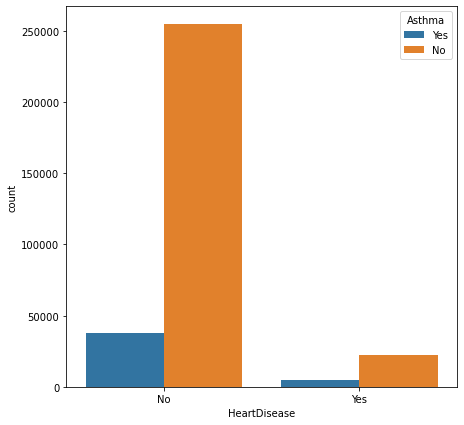

In [42]:
plt.figure(figsize=(7,7))
sns.countplot(data=df,x="HeartDisease",hue="Asthma");

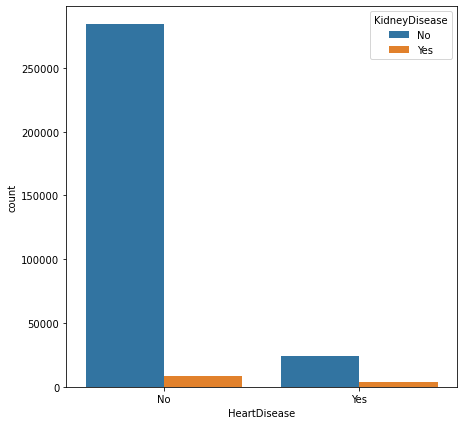

In [43]:
plt.figure(figsize=(7,7))
sns.countplot(data=df,x="HeartDisease",hue="KidneyDisease");

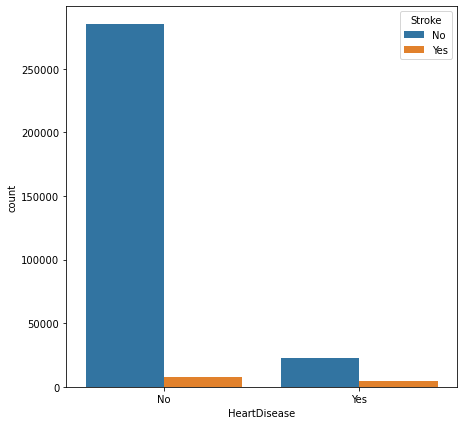

In [44]:
plt.figure(figsize=(7,7))
sns.countplot(data=df,x="HeartDisease",hue="Stroke");

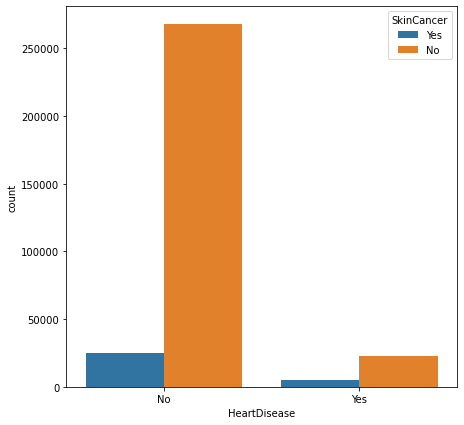

In [45]:
plt.figure(figsize=(7,7))
sns.countplot(data=df,x="HeartDisease",hue="SkinCancer");

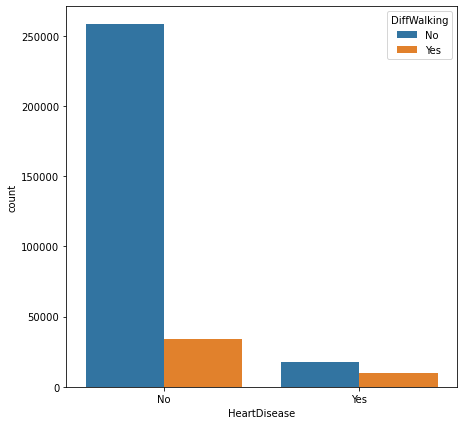

In [46]:
plt.figure(figsize=(7,7))
sns.countplot(data=df,x="HeartDisease",hue="DiffWalking");

In [47]:
# plt.figure(figsize=(7,7))
# sns.countplot(data=df,x="HeartDisease",hue="MentalHealth")

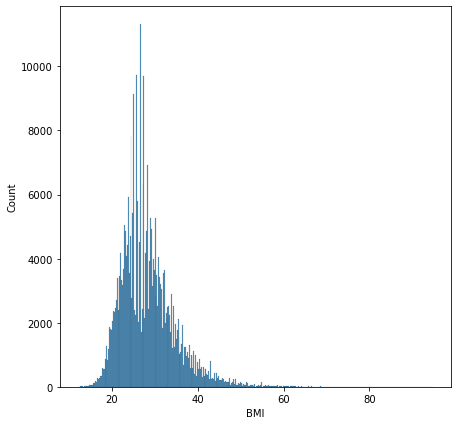

In [48]:
plt.figure(figsize=(7,7))
sns.histplot(df["BMI"])
plt.show()

# Data Preparation 

In [49]:
df_2 = df.copy()


Yes_No_dict = {"No":0, "Yes":1, "Female":1, "Male":0} 

Yes_No_List = ["Stroke", "HeartDisease", "Smoking", 
               "AlcoholDrinking","PhysicalActivity", "Sex"]

for col in Yes_No_List:
    df_2[col] = df_2[col].map(Yes_No_dict)

df_2.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,0,16.60,1,0,0,3.0,30.0,No,1,55-59,White,Yes,1,Very good,5.0,Yes,No,Yes
1,0,20.34,0,0,1,0.0,0.0,No,1,80 or older,White,No,1,Very good,7.0,No,No,No
2,0,26.58,1,0,0,20.0,30.0,No,0,65-69,White,Yes,1,Fair,8.0,Yes,No,No
3,0,24.21,0,0,0,0.0,0.0,No,1,75-79,White,No,0,Good,6.0,No,No,Yes
4,0,23.71,0,0,0,28.0,0.0,Yes,1,40-44,White,No,1,Very good,8.0,No,No,No


In [50]:
df_2["HeartDisease"].value_counts(normalize = True)

0    0.914405
1    0.085595
Name: HeartDisease, dtype: float64

In [132]:
List_1_0 = ["Stroke", "Smoking", "AlcoholDrinking","PhysicalActivity", "Sex"]

df_List_1_0 = df_2[List_1_0]

#### Encoding By using OneHotEncoder

cat = ["Diabetic", "GenHealth" , "Race"]

df_cat = df_2[cat]

ohe = OneHotEncoder(categories='auto', sparse=False)
#                     , drop="first")

df_cat_encoded = pd.DataFrame(np.squeeze(ohe.fit_transform(df_cat)), 
                              columns = ohe.get_feature_names())

##### Scaling By using StandardScaler

scaler = StandardScaler()

BMI = df_2[["BMI", "SleepTime"]]


scaled_BMI = scaler.fit_transform(BMI)

df_scaled_BMI = pd.DataFrame(np.squeeze(scaler.fit_transform(BMI)), 
                             columns = BMI.columns)

#### Concatating New DataFrames

X = pd.concat([df_cat_encoded, df_scaled_BMI, df_List_1_0], axis = 1)


We see that `df_2["HeartDisease"].value_counts(normalize = True)` results in

`
{{df_2["HeartDisease"].value_counts(normalize = True)}}`

which can be used to conclude that we have imbalances in our data so, we either can use `SMOTE` or we can set `stratify=y` in `train_test_split`. We noticed that setting set `stratify=y`, results in a better accuracy.

In [144]:

y = df_2["HeartDisease"]
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state = 42, 
                                                    test_size = 0.2) 
#                                                     , stratify=y)

print("y_train:", dict(y_train_resampled.value_counts(normalize = True)*100))
print("y_test:", dict(y_test.value_counts(normalize = True)*100))

smote = SMOTE()
X_train, y_train = smote.fit_resample(X_train, y_train)

X_train_resampled = X_train.copy()
y_train_resampled = y_train.copy()

y_train: {1: 50.0, 0: 50.0}
y_test: {0: 91.25689895089042, 1: 8.743101049109587}


# XGBoost

Training Accuracy: 76.24%
Validation accuracy: 75.22%


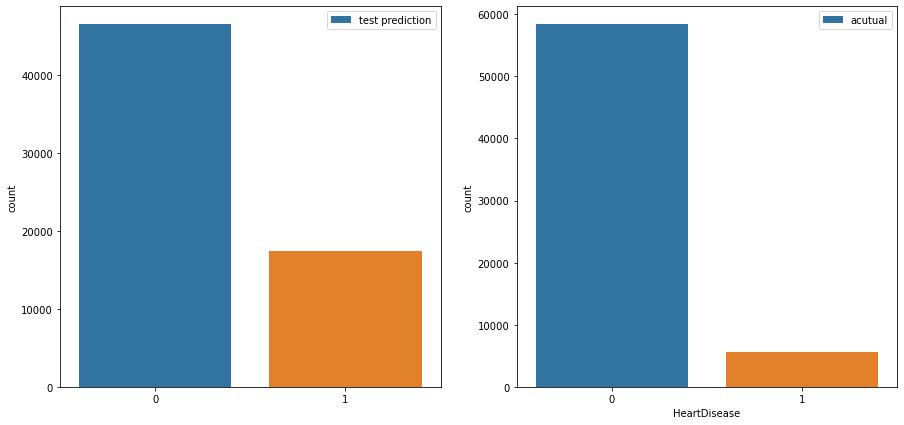

In [161]:
# {'alpha': 10,
#  'eval_metric': 'auc',
#  'max_depth': 10,
#  'n_estimators': 15,
#  'objective': 'binary:logistic',
#  'seed': 42}

clf = xgb.XGBClassifier(max_depth = 10, n_estimators=15, seed=42, alpha = 10,  
                         objective = 'binary:logistic', # eta = ,
                        eval_metric = "auc")

clf.fit(X_train_resampled, y_train_resampled)

training_preds = clf.predict(X_train_resampled)
test_preds     = clf.predict(X_test)


training_accuracy =  accuracy_score(y_train_resampled, training_preds)
test_accuracy     =  accuracy_score(y_test, test_preds)

print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))

fig, axes = plt.subplots(1,2,figsize=(15, 7))
ax0 = axes[0]
sns.countplot(test_preds, ax = ax0, label = "test prediction");
ax0.legend();
# addding second subplot
ax1 = axes[1]
sns.countplot(y_test, ax = ax1, label = "acutual");

ax1.legend();

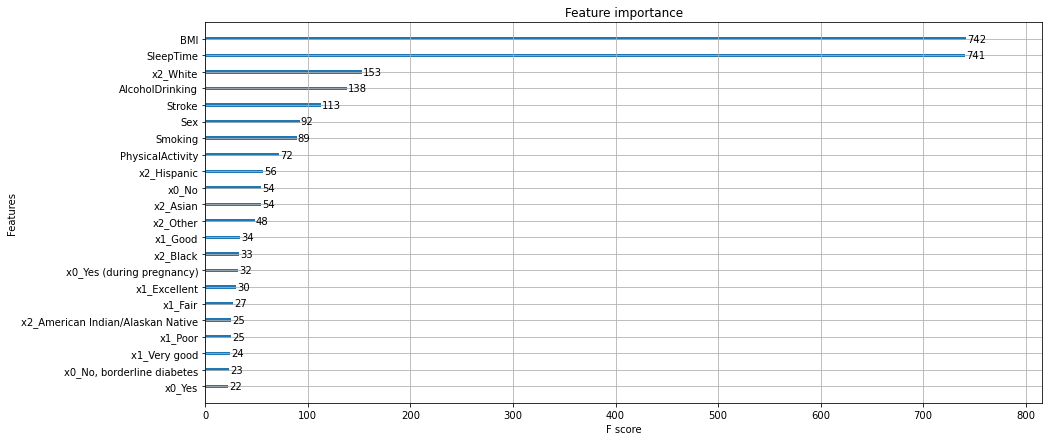

In [148]:
fig, ax = plt.subplots(1,1,figsize=(15, 7))
xgb.plot_importance(clf, ax = ax);

In [149]:
#### 
# No "Stroke", and "SleepTime" not categorical and is in BMI
# max_depth = 10, n_estimators=10, seed=42, alpha = 20, eta = 0.3, 
# objective = 'binary:logistic', eval_metric = "error"```

# gives 

# Training Accuracy: 91.51%
# Validation accuracy: 91.51%
#---------------------------------------------------------------------------------------------
### However, with stroke and and "SleepTime" not categorical and is in BMI
# max_depth = 10, n_estimators=10, seed=42, alpha = 20, eta = 0.3,
#                         objective = 'binary:logistic', eval_metric = "error"

# We got

# Training Accuracy: 91.61%
# Validation accuracy: 91.58%

#---------------------------------------------------------------------------------------------
### However, with stroke and and "SleepTime" as categorical and not in BMI
# max_depth = 10, n_estimators=10, seed=42, alpha = 20, eta = 0.3,
#                         objective = 'binary:logistic', eval_metric = "error"

# We got

# Training Accuracy: 91.62%
# Validation accuracy: 91.59%

#---------------------------------------------------------------------------------------------

### With Diabetic as a Categorical with ranges from 0-3 in the loop, and 
### "SleepTime" in BMI, with  drop="first" and eval_metric = "error" 
### and max_depth = 20, n_estimators=20, seed=42, alpha = 25,  eta = 0.3, 
### objective = 'binary:logistic', 
### eval_metric = "error"

### we got

### Training Accuracy: 91.62%
### Validation accuracy: 91.6%

#---------------------------------------------------------------------------------------------



## GridSearch For XGBoost 

By using GridSearch we find the following. It takes times to find it so, make sure that you are not running this section.

```python

best_parameters = {'alpha': 30,
 'eta': 0.3,
 'eval_metric': 'auc',
 'max_depth': 10,
 'n_estimators': 25,
 'objective': 'binary:logistic',
 'seed': 42}

```

the accuracy results that we find are:

```python
Training Accuracy: 91.61%
Validation accuracy: 91.6%
```

In [151]:
clf_param_grid = {
    "max_depth": [5, 10],
    "n_estimators": [10, 15],
    "seed": [42],
    "alpha": [10, 20, 25, 30],
#     "eta": [0.3],
    "objective" : ['binary:logistic'], 
    "eval_metric" : ["auc", "error"]
}

In [152]:
clf_grid = xgb.XGBClassifier()

clf_grid_search = GridSearchCV(clf_grid, clf_param_grid, cv = None)


# Fit to the data
clf_grid_search.fit(X_train_resampled, y_train_resampled)

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, validate_parameter

In [153]:
grid_training_preds = clf_grid_search.predict(X_train_resampled)
grid_test_preds     = clf_grid_search.predict(X_test)


grid_training_accuracy =  accuracy_score(y_train_resampled, grid_training_preds)
grid_test_accuracy     =  accuracy_score(y_test, grid_test_preds)

print('Training Accuracy: {:.4}%'.format(grid_training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(grid_test_accuracy * 100))

Training Accuracy: 76.24%
Validation accuracy: 75.22%


In [154]:
clf_grid_search.best_params_

{'alpha': 10,
 'eval_metric': 'auc',
 'max_depth': 10,
 'n_estimators': 15,
 'objective': 'binary:logistic',
 'seed': 42}

## XGBoost Final

By using the results we obtained from gird search, we are going to tune our model and we consider it as the final model.

In [155]:
### Params if we use SMOTE

# smote_params = {'alpha': 10,
#                 'eval_metric': 'auc',
#                 'max_depth': 10,
#                 'n_estimators': 15,
#                 'objective': 'binary:logistic',
#                 'seed': 42}


### Params if we do not use SMOTE
params={'alpha': 30,
 'eta': 0.3,
 'eval_metric': 'auc',
 'max_depth': 10,
 'n_estimators': 25,       
 'objective': 'binary:logistic',
 'seed': 42}

xgb_final = xgb.XGBClassifier(alpha        = 30,
                              eta          = 0.3,
                              eval_metric  = 'auc',
                              max_depth    = 10,
                              n_estimators = 25,       
                              objective    = 'binary:logistic',
                              seed         = 42)

xgb_final.fit(X_train_resampled, y_train_resampled)

XGBClassifier(alpha=30, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.3,
              eval_metric='auc', gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=10, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=25, n_jobs=0,
              num_parallel_tree=1, random_state=42, reg_alpha=30, reg_lambda=1,
              scale_pos_weight=1, seed=42, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

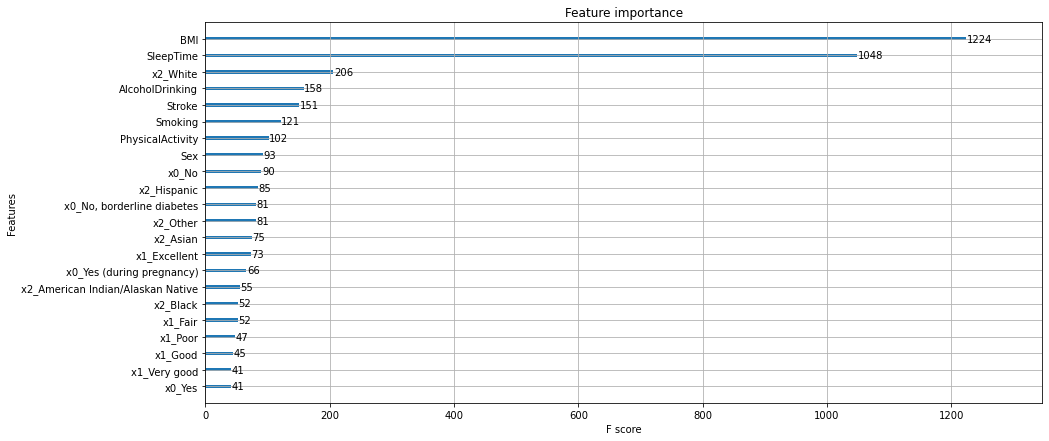

In [156]:
fig, ax = plt.subplots(1,1,figsize=(15, 7))
xgb.plot_importance(xgb_final, ax = ax);

In [158]:
training_preds = xgb_final.predict(X_train_resampled)
test_preds     = xgb_final.predict(X_test)

## Accuracy
training_accuracy =  accuracy_score(y_train_resampled, training_preds)
test_accuracy     =  accuracy_score(y_test, test_preds)

### ROC and AUC
# ROC
train_fpr, train_tpr, train_thresh = roc_curve(y_train_resampled, training_preds)
test_fpr , test_tpr , test_thresh = roc_curve(y_test, test_preds)
# AUC
train_auc = auc(train_fpr, train_tpr)
test_auc = auc(test_fpr, test_tpr)

print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))
print()
print('Training AUC: {:.4}'.format(train_auc))
print('Validation AUC: {:.4}'.format(test_auc))

Training Accuracy: 76.84%
Validation accuracy: 76.17%

Training AUC: 0.7684
Validation AUC: 0.7032


# Random Forest

In [64]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(criterion="entropy", bootstrap = True)

rf.fit(X_train_resampled, y_train_resampled)

training_preds = rf.predict(X_train_resampled)
test_preds     = rf.predict(X_test)


training_accuracy = accuracy_score(y_train_resampled, training_preds)
test_accuracy     = accuracy_score(y_test, test_preds)

print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))

In [ ]:
# param_grid ={"max_depth": [5, 10, 15, 20],
#             "min_samples_leaf": [5, 10, 15],
#             "min_samples_split": [2, 3, 6]}

In [ ]:

# grid_clf = GridSearchCV(rf, param_grid, scoring='accuracy', cv=None,
#                                                              n_jobs=1)
# grid_clf.fit(X_train_resampled, y_train_resampled)

# best_parameters = grid_clf.best_params_

# print('Grid Search found the following optimal parameters: ')
# for param_name in sorted(best_parameters.keys()):
#     print('%s: %r' % (param_name, best_parameters[param_name]))

# training_preds = grid_clf.predict(X_train_resampled)
# test_preds     = grid_clf.predict(X_test)
# training_accuracy = accuracy_score(y_train_resampled, training_preds)
# test_accuracy = accuracy_score(y_test, test_preds)

# print('')
# print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
# print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))